In [116]:
from google.cloud.sql.connector import connector
import pg8000.native
import sqlalchemy
import yfinance as yf
from datetime import date
from datetime import timedelta
import pandas as pd
import os

In [119]:
#The credential path will be where the json file of secret keys is stored on your machine.

credential_path = "<File Path to where the json file of secret keys is stored in your local machine>"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

#getconn function will have the parameters of your GCP's postgresql instance.
def getconn() -> pg8000.native.Connection:
    conn: pg8000.native.Connection = connector.connect(
        "<Connection Name>",
        "pg8000",
        user="<postgresql_username>",
        password="<postgresql_password>",
        db="<postgresql_db>"
        # enable_iam_auth=True
    )
    return conn

pool = sqlalchemy.create_engine(
    "postgresql+pg8000://",
    creator=getconn,
)

In [120]:
with pool.connect() as db_conn:
    
    #create an empty dictionary of companies info
    companies_info = {}

    #Function to get the information of Companies which will return a dictionary
    def get_company_info(ticker):
        """
        Function that gets the information of companies. 
        Information such as Symbol, Name, Sector, Exchange, Website and Zip code of the company
        ***IMPORTANT: This function is to be run only once to get the information of all the companies in the Database. Once the information is stored in the database, it does not need to be updated.
        """
        stock_info = yf.Ticker('{}'.format(ticker)).info
        companies_info[ticker] = {}
        companies_info[ticker]['Company_Symbol'] = stock_info['symbol']
        companies_info[ticker]['Company Name'] = stock_info['shortName']
        companies_info[ticker]['Sector'] = stock_info['sector']
        companies_info[ticker]['Exchange'] = stock_info['exchange']
        companies_info[ticker]['Website'] = stock_info['website']
        companies_info[ticker]['Zip'] = stock_info['zip']
    
    top_companies = ['AAPL','MSFT','GOOGL','SAR','AMZN','TSLA','FB','NVDA','TSM']
    for ticker in top_companies:
        get_company_info(ticker)
        print('{} Company Information Retrieved'.format(ticker))
    
    company_info = pd.DataFrame.from_dict(companies_info, orient='index')

    company_info.to_sql('company_information', con=db_conn, if_exists='replace')

    query = """ALTER TABLE company_information ADD PRIMARY KEY ("Company_Symbol");"""
    db_conn.execute(query)  

AAPL Company Information Retrieved
MSFT Company Information Retrieved
GOOGL Company Information Retrieved
SAR Company Information Retrieved
AMZN Company Information Retrieved
TSLA Company Information Retrieved
FB Company Information Retrieved
NVDA Company Information Retrieved
TSM Company Information Retrieved


In [121]:
with pool.connect() as db_conn:
    result = db_conn.execute("select * from company_information")
    for row in result:
        print(row)

('AAPL', 'AAPL', 'Apple Inc.', 'Technology', 'NMS', 'https://www.apple.com', '95014')
('MSFT', 'MSFT', 'Microsoft Corporation', 'Technology', 'NMS', 'https://www.microsoft.com', '98052-6399')
('GOOGL', 'GOOGL', 'Alphabet Inc.', 'Communication Services', 'NMS', 'https://www.abc.xyz', '94043')
('SAR', 'SAR', 'Saratoga Investment Corp New', 'Financial Services', 'NYQ', 'https://www.saratogainvestmentcorp.com', '10022')
('AMZN', 'AMZN', 'Amazon.com, Inc.', 'Consumer Cyclical', 'NMS', 'https://www.amazon.com', '98109-5210')
('TSLA', 'TSLA', 'Tesla, Inc.', 'Consumer Cyclical', 'NMS', 'https://www.tesla.com', '78725')
('FB', 'FB', 'Meta Platforms, Inc.', 'Communication Services', 'NMS', 'https://investor.fb.com', '94025')
('NVDA', 'NVDA', 'NVIDIA Corporation', 'Technology', 'NMS', 'https://www.nvidia.com', '95051')
('TSM', 'TSM', 'Taiwan Semiconductor Manufactur', 'Technology', 'NYQ', 'https://www.tsmc.com', '300-78')


In [126]:
with pool.connect() as db_conn:
    
    def create_prices_table(ticker):

        """
        Create a daily prices table in the database. 
        This function essentially takes in a company symbol as the input, generates a price_history dataframe and then builds a table of daily prices
        using that dataframe. 
        So, we don't have to manually create the columns.
        A Query is also being run which makes the company symbol and date as the primary keys.
        ***IMPORTANT: This function is to be run only once to create the daily_prices table in the database and fill it with the historical stock prices of one company. 
        Once the data is in the table, it does not to be updated since all of this is historical data.
        """

        price_history = yf.Ticker('{}'.format(ticker)).history(period='5y', interval='1d')

        #some formatting
        price_history = price_history.reset_index()
        price_history['symbol'] = '{}'.format(ticker)
        price_history =price_history.drop(['Stock Splits'], axis=1)
        price_history['Date'] = pd.to_datetime(price_history['Date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

        price_history.to_sql('daily_prices', con=db_conn, if_exists='replace', index=False)

        #creating company symbol as the primary key
        query = """ALTER TABLE daily_prices ADD PRIMARY KEY ("symbol", "Date");"""
        db_conn.execute(query)

    
        return 'Daily prices table created'
    
    create_prices_table('AAPL')

In [127]:
with pool.connect() as db_conn:
    
    def insert_historical_prices(ticker):

        """
        Inserts the historical prices of all the top 100 companies into the db.
        The function takes input as a company symbol, generates a price_history dataframe, does some formatting and then inserts the rows of that 
        dataframe into the daily_prices table.
        ***IMPORTANT: This function is to be run only once to insert all the historical stock data of all the companies.
        Once the data is inserted, that data is not to be updated.
        """
        price_history = yf.Ticker('{}'.format(ticker)).history(period='5y', interval='1d')

        price_history = price_history.fillna(0)

        #some formatting
        price_history = price_history.reset_index()
        price_history['symbol'] = '{}'.format(ticker)
        price_history = price_history.drop(['Stock Splits'], axis=1)
        price_history['Date'] = pd.to_datetime(price_history['Date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')

        price_history.to_sql('daily_prices', con=db_conn, if_exists='append', index=False)

        return "Historical Prices Inserted"

    #Adding historical prices of 8 companies.
    top_companies = ['MSFT','GOOGL','SAR','AMZN','TSLA','FB','TSM']
    for ticker in top_companies:
        insert_historical_prices(ticker)
        print("{} Historical Data added".format(ticker))  

MSFT Historical Data added
GOOGL Historical Data added
SAR Historical Data added
AMZN Historical Data added
TSLA Historical Data added
FB Historical Data added
TSM Historical Data added


In [128]:
#Query to retrive values from the daily_prices table in the database.
with pool.connect() as db_conn:
    result = db_conn.execute("select * from daily_prices")
    for row in result:
        print(row)

('2017-03-13T00:00:00Z', 32.77414630172253, 32.91104629406604, 32.76706539183178, 32.85675811767578, 69686800, 0.0, 'AAPL')
('2017-03-14T00:00:00Z', 32.88036938711351, 32.96298121772806, 32.771789413379516, 32.80719757080078, 61236400, 0.0, 'AAPL')
('2017-03-15T00:00:00Z', 32.90632833689322, 33.222620986678486, 32.816632008688835, 33.154170989990234, 102767200, 0.0, 'AAPL')
('2017-03-16T00:00:00Z', 33.21554267197204, 33.28635537863024, 33.10696270820495, 33.20846176147461, 76928000, 0.0, 'AAPL')
('2017-03-17T00:00:00Z', 33.28163484527846, 33.28163484527846, 33.01963034179082, 33.043235778808594, 175540000, 0.0, 'AAPL')
('2017-03-20T00:00:00Z', 33.14001142563673, 33.39965684175873, 33.099885061633195, 33.39021682739258, 86168000, 0.0, 'AAPL')
('2017-03-21T00:00:00Z', 33.543643363093636, 33.706511533629055, 32.98186703033308, 33.00783157348633, 158119600, 0.0, 'AAPL')
('2017-03-22T00:00:00Z', 33.01019830705467, 33.42326834292286, 32.98895196792951, 33.38077926635742, 103440800, 0.0, 'AAP

In [ ]:
with pool.connect() as db_conn:
    
    today = date.today()
    yesterday = today - timedelta(days = 1)

    def insert_latest_stock_data(ticker):
        """
        This function generates the latest stock data for the ticker of the company passed into the function.
        It will take yesterday's date as the starting date and today's date as the ending date to generate the latest stock data for every day.
        Once it generates the latest stock data, it will then append that row into the daily_prices table.
        ***IMPORTANT: This is the function that has to be run on a daily basis to keep the daily_prices table updated with the stock data of every company.
        """

        price_history = yf.Ticker('{}'.format(ticker)).history(start = '{}'.format(yesterday), end='{}'.format(today))

        #some formatting
        price_history = price_history.reset_index()
        price_history['symbol'] = '{}'.format(ticker)
        price_history = price_history.drop(['Stock Splits'], axis=1)
        price_history['Date'] = pd.to_datetime(price_history['Date']).dt.strftime('%Y-%m-%dT%H:%M:%SZ')


        price_history.to_sql('daily_prices', con=db_conn, if_exists='append', index=False)

        return "Latest Stock Prices Inserted"   
    
    top_companies = ['MSFT','GOOGL','SAR','AMZN','TSLA','FB','TSM']
    for ticker in top_companies:
        insert_latest_stock_data(ticker)
        print("{} Latest Stock Data added".format(ticker))

In [131]:
#Querying from the database and storing it into another database.
with pool.connect() as db_conn:

    prices_df =  pd.read_sql('daily_prices', db_conn, index_col=['symbol', 'Date'])
    

<AxesSubplot:xlabel='symbol,Date'>

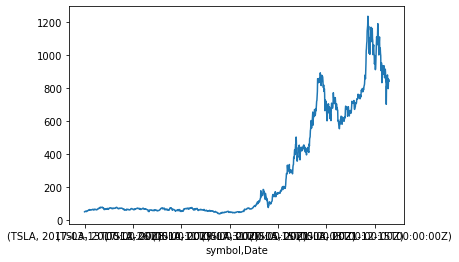

In [134]:
#Plotting the 5 year historical Open price for Tesla's Stock.
prices_df.loc[['TSLA']]['Open'].plot()